### GEO ANALYSIS

### INSTALLING NECESSARY LIBRARIES

In [73]:
! pip install pyreadr pandas matplotlib seaborn geopandas contextily networkx scipy --quiet

### IMPORTING NECESSARY LIBRARIES

In [74]:
import pyreadr
import pandas as pd
import geopandas as gpd
import networkx as nx

### LOAD AND PROCESS DATA

In [75]:
PATH = "/Users/amarnathreddykalluru/PycharmProjects/Resilience/data/portarthur_sd_df_2019.rdata"

result = pyreadr.read_r(PATH)
df = result['portarthur_sd_df_2019']
df["origin_census_block_group"] = df["origin_census_block_group"].astype(str)
df["destination_cbg"] = df["destination_cbg"].astype(str)
df["device_count"] = pd.to_numeric(df["device_count"], errors="coerce")
df["destination_device_count"] = pd.to_numeric(df["destination_device_count"], errors="coerce")
df["year"] = df["year"].astype(int)
df["uid"] = df["uid"].astype(int)
df["date"] = pd.to_datetime("2019-01-01") + pd.to_timedelta(df["uid"] - 1, unit="D")

county_map = {
    "48199": "Jefferson County",
    "48245": "Jeff Davis County",
    "48361": "Orange County"
}

In [76]:
in_degree_df = df.groupby('destination_cbg')['destination_device_count'].sum().reset_index()
in_degree_df.rename(columns={'destination_cbg': 'cbg', 'destination_device_count': 'in_degree'}, inplace=True)
in_degree_df = in_degree_df.sort_values(by='in_degree', ascending=False).reset_index(drop=True)
print(in_degree_df.head())

            cbg  in_degree
0  482450003082     552224
1  482450069001     531749
2  481990303002     390668
3  482450012002     365884
4  482450070013     347833


In [ ]:
!wget https://www2.census.gov/geo/tiger/TIGER2019/BG/tl_2019_48_bg.zip
!unzip tl_2019_48_bg.zip

In [78]:
cbg_shapes = gpd.read_file("tl_2019_48_bg.shp")
cbg_shapes['cbg'] = cbg_shapes['STATEFP'] + cbg_shapes['COUNTYFP'] + cbg_shapes['TRACTCE'] + cbg_shapes['BLKGRPCE']
in_degree_df['cbg'] = in_degree_df['cbg'].astype(str).str.zfill(12)
merged_df = cbg_shapes.merge(in_degree_df, on='cbg')

In [79]:
merged_df.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,cbg,in_degree
0,48,245,010901,3,482450109013,Block Group 3,G5030,S,1112904,0,+29.9682079,-093.9717278,"POLYGON ((-93.98142 29.97156, -93.98092 29.972...",482450109013,88321
1,48,245,002000,1,482450020001,Block Group 1,G5030,S,401807,0,+30.0593112,-094.1040586,"POLYGON ((-94.10852 30.06192, -94.10765 30.061...",482450020001,17297
2,48,245,000600,6,482450006006,Block Group 6,G5030,S,550523,0,+30.1227610,-094.1324367,"POLYGON ((-94.13822 30.12416, -94.13801 30.124...",482450006006,29796
3,48,245,000310,3,482450003103,Block Group 3,G5030,S,418747,0,+30.0770686,-094.1743652,"POLYGON ((-94.17765 30.07685, -94.17763 30.077...",482450003103,88283
4,48,245,011500,1,482450115001,Block Group 1,G5030,S,198785571,1102986,+29.9415957,-094.3722873,"POLYGON ((-94.44511 30.11202, -94.44491 30.113...",482450115001,123889


### LETS MERGE OUR RESILIENCE DATA WITH THIS

In [80]:
resilience_df = pd.read_csv("cbg_resilience_summary.csv")
resilience_df['CBG'] = resilience_df['CBG'].astype(str).str.zfill(12)
resilience_merged_df = resilience_df.merge(merged_df, left_on ='CBG', right_on='cbg').drop(columns='CBG')
resilience_merged_df.head()

,Resilience,Robustness,Vulnerability,Status,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,cbg,in_degree
0,6.494745,0.004467,0.001966,Recovered,48,245,011101,1,482450111011,Block Group 1,G5030,S,1279494,0,+29.9685938,-094.0109663,"POLYGON ((-94.01891 29.96591, -94.01875 29.966...",482450111011,91106
1,0.000000,0.000000,0.000000,No Trend Shown,48,199,030300,3,481990303003,Block Group 3,G5030,S,164617321,731108,+30.4734097,-094.3209015,"POLYGON ((-94.40065 30.52694, -94.40051 30.526...",481990303003,43800
2,2.105740,0.006678,0.001934,Recovered,48,245,000308,2,482450003082,Block Group 2,G5030,S,1987874,0,+30.1226577,-094.1629690,"POLYGON ((-94.16904 30.13341, -94.16871 30.133...",482450003082,552224
3,0.000000,0.000000,0.000000,No Trend Shown,48,245,010902,2,482450109022,Block Group 2,G5030,S,1069942,0,+29.9644876,-093.9581534,"POLYGON ((-93.96531 29.96578, -93.964 29.96718...",482450109022,67618
4,2.550028,0.001101,0.002627,Recovered,48,245,000307,1,482450003071,Block Group 1,G5030,S,9621020,275142,+30.1184385,-094.1936713,"POLYGON ((-94.21272 30.13297, -94.20643 30.133...",482450003071,299357


### INDEGREE HEAT MAP

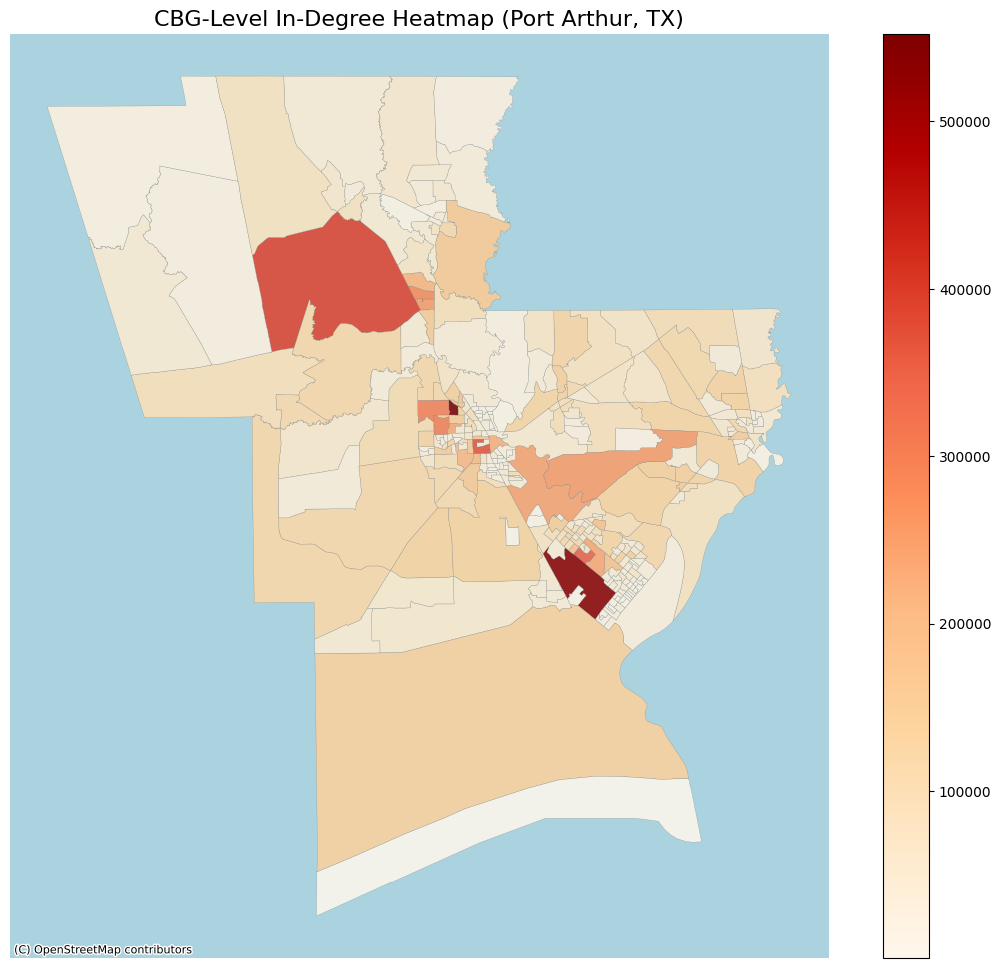

In [81]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # for base map tiles

gdf = resilience_merged_df.copy()

gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# Step 3: Plot choropleth
fig, ax = plt.subplots(figsize=(14, 12))

gdf.plot(
    column='in_degree',
    cmap='OrRd',
    linewidth=0.2,
    edgecolor='gray',
    legend=True,
    ax=ax,
    alpha=0.85
)

# Step 4: Add base map (OpenStreetMap)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Format
ax.set_title("CBG-Level In-Degree Heatmap (Port Arthur, TX)", fontsize=16)
ax.axis('off')

plt.show()

### RESILIENCE HEAT MAP

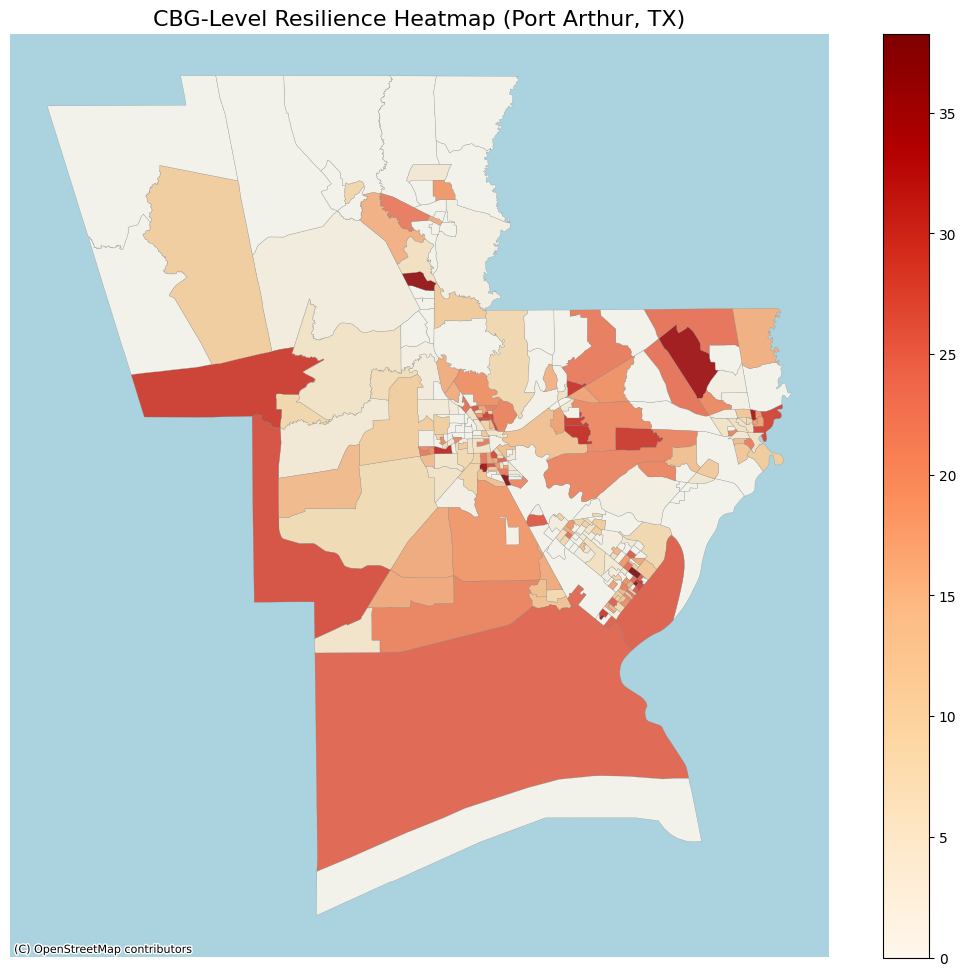

In [82]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # for base map tiles

gdf = resilience_merged_df.copy()

gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# Step 3: Plot choropleth
fig, ax = plt.subplots(figsize=(14, 12))

gdf.plot(
    column='Resilience',
    cmap='OrRd',
    linewidth=0.2,
    edgecolor='gray',
    legend=True,
    ax=ax,
    alpha=0.85
)

# Step 4: Add base map (OpenStreetMap)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Format
ax.set_title("CBG-Level Resilience Heatmap (Port Arthur, TX)", fontsize=16)
ax.axis('off')

plt.show()

### Vulnerability Heat Map

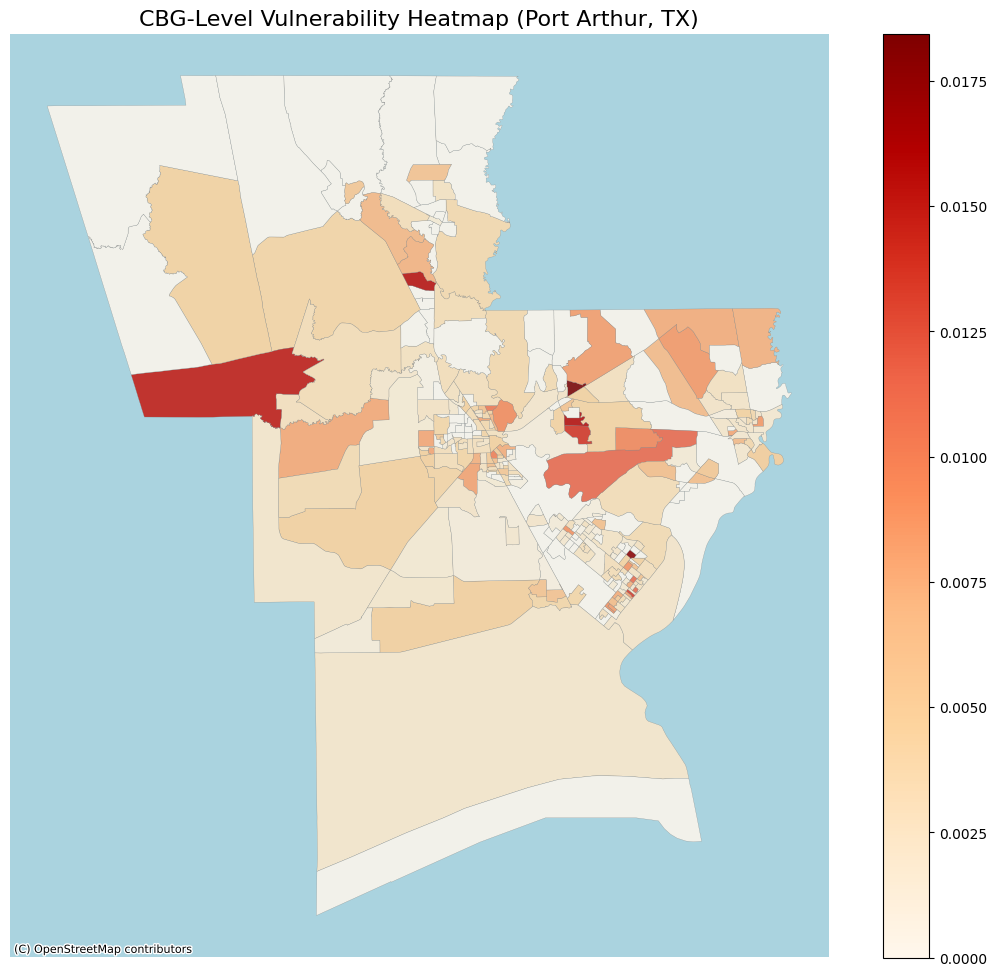

In [86]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # for base map tiles

gdf = resilience_merged_df.copy()

gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# Step 3: Plot choropleth
fig, ax = plt.subplots(figsize=(14, 12))

gdf.plot(
    column='Vulnerability',
    cmap='OrRd',
    linewidth=0.2,
    edgecolor='gray',
    legend=True,
    ax=ax,
    alpha=0.85
)

# Step 4: Add base map (OpenStreetMap)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Format
ax.set_title("CBG-Level Vulnerability Heatmap (Port Arthur, TX)", fontsize=16)
ax.axis('off')

plt.show()

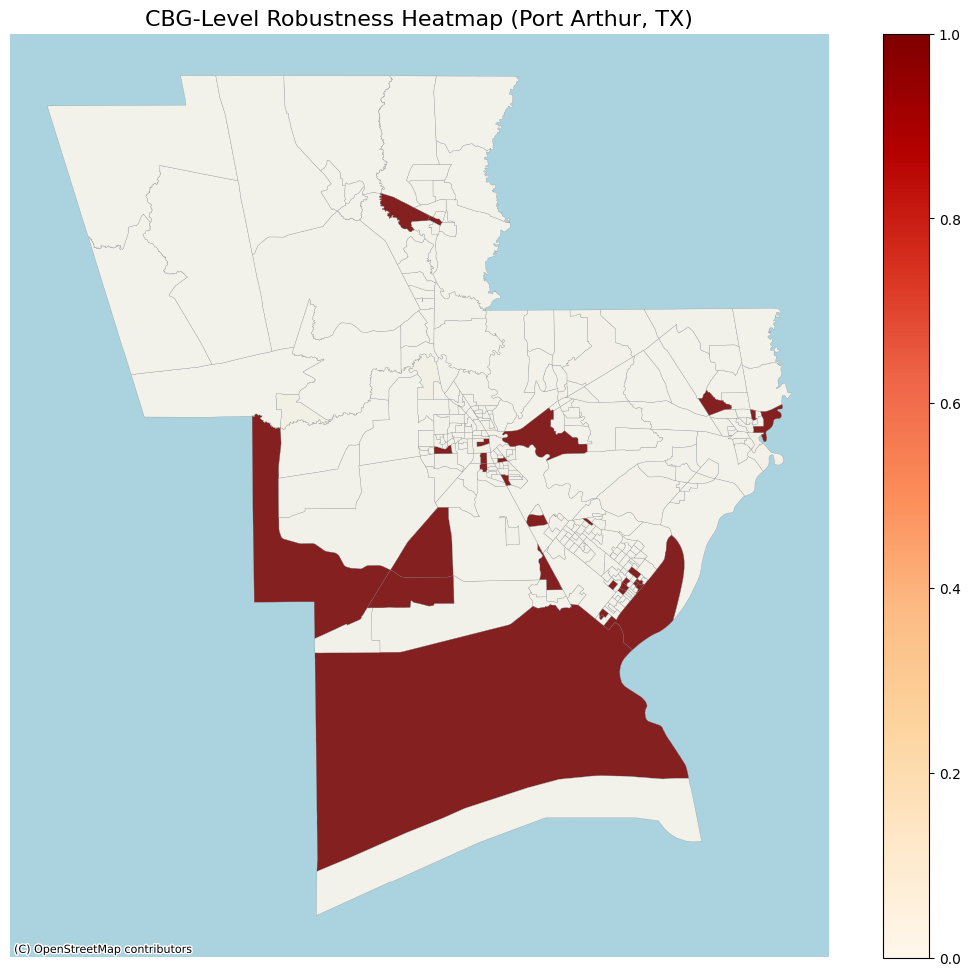

In [87]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # for base map tiles

gdf = resilience_merged_df.copy()

gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# Step 3: Plot choropleth
fig, ax = plt.subplots(figsize=(14, 12))

gdf.plot(
    column='Robustness',
    cmap='OrRd',
    linewidth=0.2,
    edgecolor='gray',
    legend=True,
    ax=ax,
    alpha=0.85
)

# Step 4: Add base map (OpenStreetMap)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Format
ax.set_title("CBG-Level Robustness Heatmap (Port Arthur, TX)", fontsize=16)
ax.axis('off')

plt.show()

### NETWORK ANALYSIS

In [88]:
network_df = df.copy()

network_df = network_df.groupby(['origin_census_block_group', 'destination_cbg'])['destination_device_count'].sum().reset_index()
network_df.rename(columns={'destination_cbg': 'to_cbg', 'origin_census_block_group': 'from_cbg', 'destination_device_count': 'count'}, inplace=True)
network_df['from_cbg'] = network_df['from_cbg'].astype(str).str.zfill(12)
network_df['to_cbg'] = network_df['to_cbg'].astype(str).str.zfill(12)

network_df.head()

,from_cbg,to_cbg,count
0,481990301001,481990301001,21139
1,481990301001,481990301002,1224
2,481990301001,481990301003,1883
3,481990301001,481990302001,15
4,481990301001,481990302002,221


In [89]:

# Initialize graph
G = nx.DiGraph()

# Add edges with weights
for _, row in network_df.iterrows():
    origin = row['from_cbg']
    dest = row['to_cbg']
    weight = row['count']
    if weight > 0:
        G.add_edge(origin, dest, weight=weight)

In [90]:
in_degree = dict(G.in_degree(weight='weight'))
out_degree = dict(G.out_degree(weight='weight'))

# Convert to DataFrames for further merging or plotting
in_df = pd.DataFrame(in_degree.items(), columns=['cbg', 'in_degree'])
out_df = pd.DataFrame(out_degree.items(), columns=['cbg', 'out_degree'])


In [91]:
pagerank = nx.pagerank(G, weight='weight')
pr_df = pd.DataFrame(pagerank.items(), columns=['cbg', 'pagerank'])

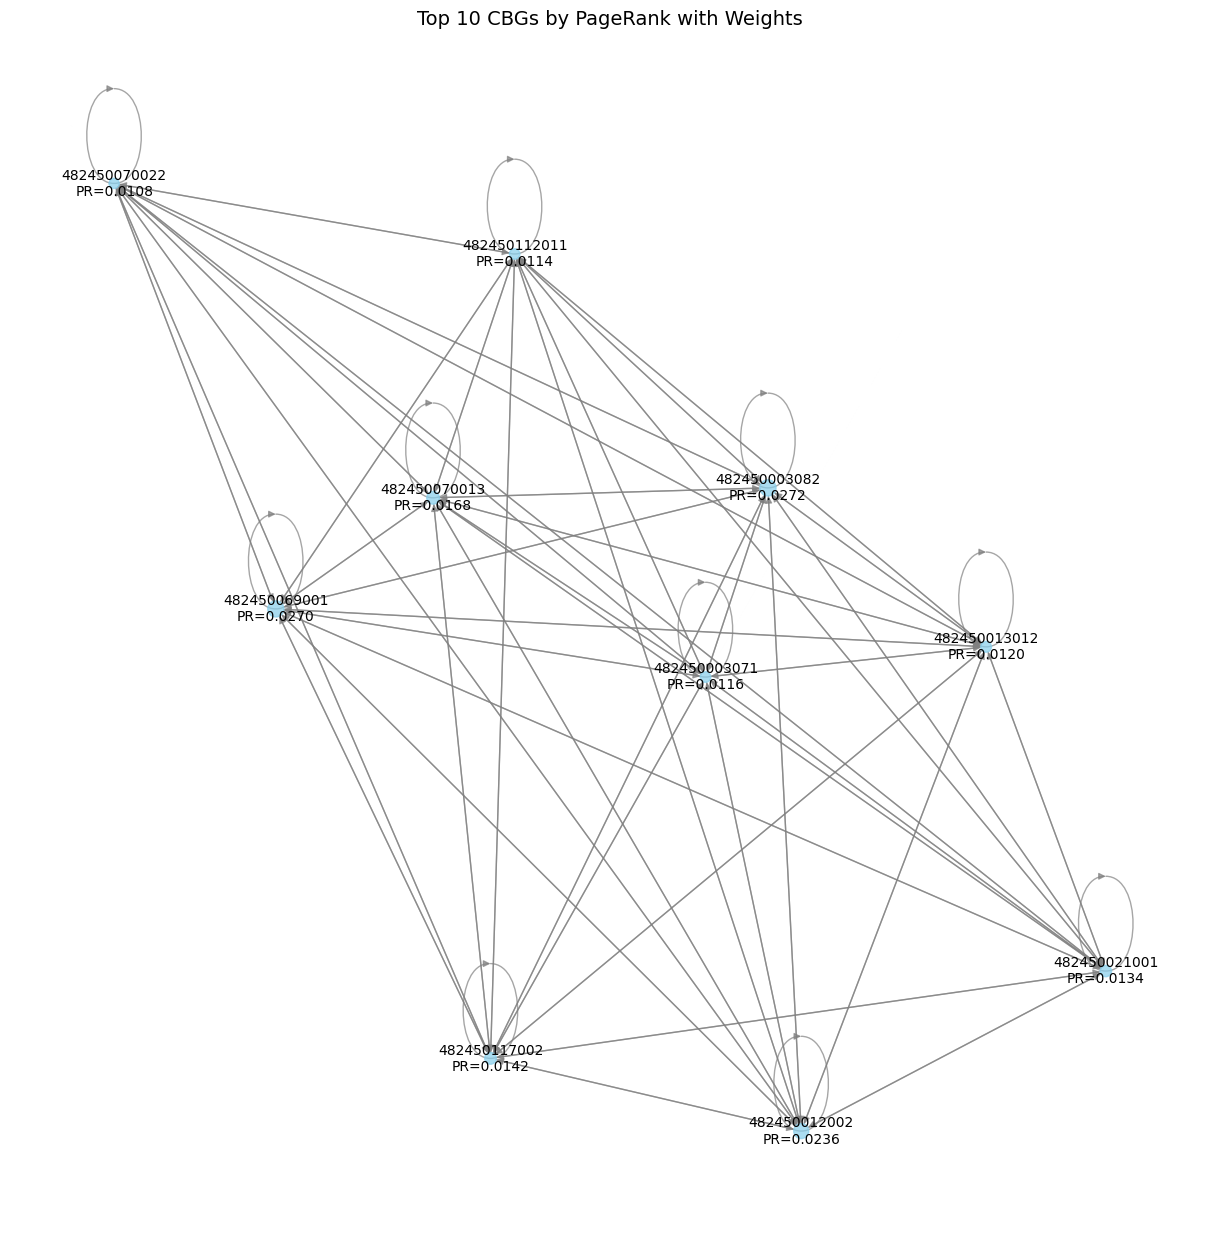

In [92]:
top_nodes = sorted(pagerank, key=pagerank.get, reverse=True)[:10]
H = G.subgraph(top_nodes)

pos = nx.spring_layout(H, k=0.5, seed=42)
node_sizes = [pagerank[n] * 5000 for n in H.nodes()]  # Adjust scaling
plt.figure(figsize=(12, 12))
edge_labels = {(u, v): f"{d['weight']}" for u, v, d in H.edges(data=True)}
nx.draw(H, pos, node_size=node_sizes, node_color='skyblue', edge_color='gray', arrows=True, alpha=0.7)
labels = {node: f"{node}\nPR={pagerank[node]:.4f}" for node in H.nodes()}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=10)
plt.title("Top 10 CBGs by PageRank with Weights", fontsize=14)
plt.axis('off')
plt.show()

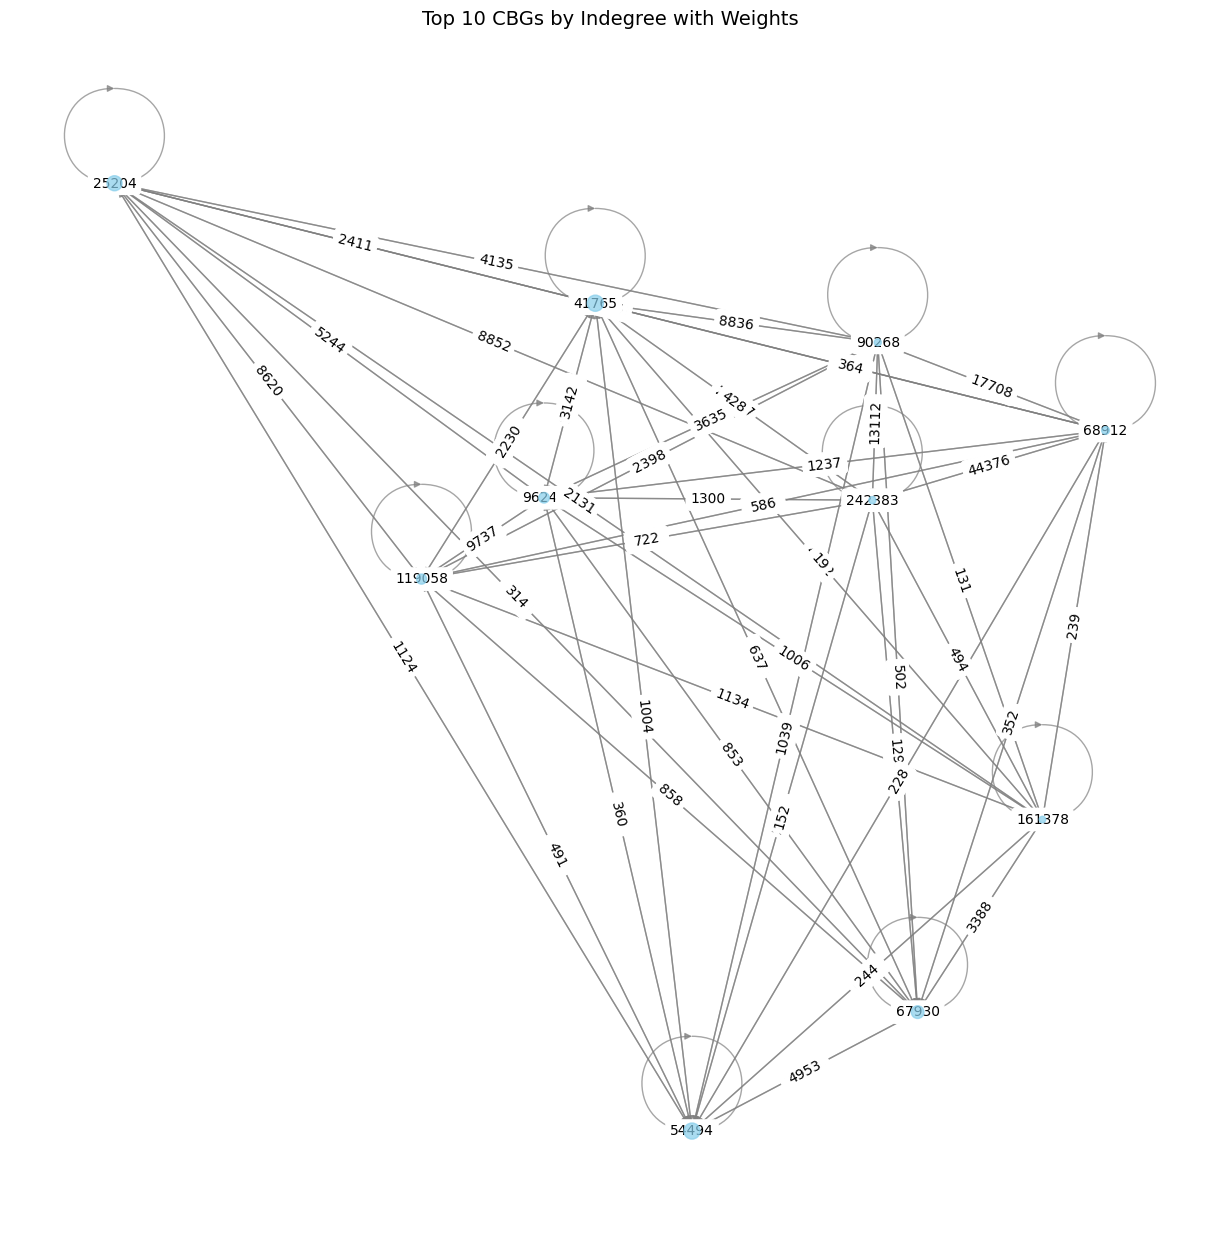

In [93]:
top_nodes = sorted(in_degree, key=in_degree.get, reverse=True)[:10]
H = G.subgraph(top_nodes)

pos = nx.spring_layout(H, k=0.5, seed=42)
node_sizes = [pagerank[n] * 5000 for n in H.nodes()]  # Adjust scaling
plt.figure(figsize=(12, 12))
edge_labels = {(u, v): f"{d['weight']}" for u, v, d in H.edges(data=True)}
nx.draw(H, pos, node_size=node_sizes, node_color='skyblue', edge_color='gray', arrows=True, alpha=0.7)
labels = {node: f"{node}\nPR={pagerank[node]:.4f}" for node in H.nodes()}
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=10)
plt.title("Top 10 CBGs by Indegree with Weights", fontsize=14)
plt.axis('off')
plt.show()